In [21]:
import argparse
import os
import torch
#from exp.exp_main import Exp_Main
import random
import numpy as np
from exp.exp_basic import Exp_Basic
import sys
from torch.utils.data import DataLoader


device="cuda:3"
device_n="3"
dataset_name="freqshape_274" 
SEQ_LEN=200
CHANNEL=1
DATASET_PATH="/home/hbs/TS/XTS/TimeX/datasets/SeqCombSingle"
CLASS_NUMBER=4

# Simulate command-line arguments
update_dict= {
    "--random_seed": "42",
    #"--seed": "42",
    "--is_training": "1",
    "--root_path": "./dataset/",
    "--data_path": "ETTh1.csv",
    "--model_id": dataset_name,
    "--model": "PatchTST",
    "--data": dataset_name,
    "--features": "S",
    "--seq_len": SEQ_LEN,
    "--pred_len": SEQ_LEN, ##!!!!
    "--enc_in": "1",
    "--e_layers": "3",
    "--n_heads": "4",
    "--d_model": "16",
    "--d_ff": "128", # !!!
    "--dropout": "0.3",
    "--fc_dropout": "0.3",
    "--head_dropout": "0",
    "--patch_len": "1",
    "--stride": "1",
    "--des": "Exp",
    "--train_epochs": "100",
    "--itr": "1",
    "--batch_size": "16", # !!!
    "--learning_rate": "0.0001"
}


In [22]:
parser = argparse.ArgumentParser(description='Autoformer & Transformer family for Time Series Forecasting')

# random seed
parser.add_argument('--random_seed', type=int, default=2021, help='random seed')

# basic config
parser.add_argument('--is_training', type=int, required=True, default=1, help='status')
parser.add_argument('--model_id', type=str, required=True, default='test', help='model id')
parser.add_argument('--model', type=str, required=True, default='Autoformer',
                    help='model name, options: [Autoformer, Informer, Transformer]')

# data loader
parser.add_argument('--data', type=str, required=True, default='ETTm1', help='dataset type')
parser.add_argument('--root_path', type=str, default='./data/ETT/', help='root path of the data file')
parser.add_argument('--data_path', type=str, default='ETTh1.csv', help='data file')
parser.add_argument('--features', type=str, default='M',
                    help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')
parser.add_argument('--target', type=str, default='OT', help='target feature in S or MS task')
parser.add_argument('--freq', type=str, default='h',
                    help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
parser.add_argument('--checkpoints', type=str, default='./checkpoints/', help='location of model checkpoints')

# forecasting task
parser.add_argument('--seq_len', type=int, default=96, help='input sequence length')
parser.add_argument('--label_len', type=int, default=48, help='start token length')
parser.add_argument('--pred_len', type=int, default=96, help='prediction sequence length')


# DLinear
#parser.add_argument('--individual', action='store_true', default=False, help='DLinear: a linear layer for each variate(channel) individually')

# PatchTST
parser.add_argument('--fc_dropout', type=float, default=0.05, help='fully connected dropout')
parser.add_argument('--head_dropout', type=float, default=0.0, help='head dropout')
parser.add_argument('--patch_len', type=int, default=16, help='patch length')
parser.add_argument('--stride', type=int, default=8, help='stride')
parser.add_argument('--padding_patch', default='None', help='None: None; end: padding on the end')
parser.add_argument('--revin', type=int, default=1, help='RevIN; True 1 False 0')
parser.add_argument('--affine', type=int, default=0, help='RevIN-affine; True 1 False 0')
parser.add_argument('--subtract_last', type=int, default=0, help='0: subtract mean; 1: subtract last')
parser.add_argument('--decomposition', type=int, default=0, help='decomposition; True 1 False 0')
parser.add_argument('--kernel_size', type=int, default=25, help='decomposition-kernel')
parser.add_argument('--individual', type=int, default=0, help='individual head; True 1 False 0')

# Formers 
parser.add_argument('--embed_type', type=int, default=0, help='0: default 1: value embedding + temporal embedding + positional embedding 2: value embedding + temporal embedding 3: value embedding + positional embedding 4: value embedding')
parser.add_argument('--enc_in', type=int, default=1, help='encoder input size') # DLinear with --individual, use this hyperparameter as the number of channels
parser.add_argument('--dec_in', type=int, default=1, help='decoder input size') # !!!
parser.add_argument('--c_out', type=int, default=1, help='output size') # !!!
parser.add_argument('--d_model', type=int, default=512, help='dimension of model')
parser.add_argument('--n_heads', type=int, default=8, help='num of heads')
parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')
parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')
parser.add_argument('--d_ff', type=int, default=2048, help='dimension of fcn')
parser.add_argument('--moving_avg', type=int, default=25, help='window size of moving average')
parser.add_argument('--factor', type=int, default=1, help='attn factor')
parser.add_argument('--distil', action='store_false',
                    help='whether to use distilling in encoder, using this argument means not using distilling',
                    default=True)
parser.add_argument('--dropout', type=float, default=0.05, help='dropout')
parser.add_argument('--embed', type=str, default='timeF',
                    help='time features encoding, options:[timeF, fixed, learned]')
parser.add_argument('--activation', type=str, default='gelu', help='activation')
parser.add_argument('--output_attention', action='store_true', help='whether to output attention in ecoder')
parser.add_argument('--do_predict', action='store_true', help='whether to predict unseen future data')

# optimization
parser.add_argument('--num_workers', type=int, default=10, help='data loader num workers')
parser.add_argument('--itr', type=int, default=2, help='experiments times')
parser.add_argument('--train_epochs', type=int, default=100, help='train epochs')
parser.add_argument('--batch_size', type=int, default=128, help='batch size of train input data')
parser.add_argument('--patience', type=int, default=100, help='early stopping patience')
parser.add_argument('--learning_rate', type=float, default=0.0001, help='optimizer learning rate')
parser.add_argument('--des', type=str, default='test', help='exp description')
parser.add_argument('--loss', type=str, default='mse', help='loss function')
parser.add_argument('--lradj', type=str, default='type3', help='adjust learning rate')
parser.add_argument('--pct_start', type=float, default=0.3, help='pct_start')
parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)

# GPU
parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
parser.add_argument('--gpu', type=int, default=device_n, help='gpu')
parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
parser.add_argument('--devices', type=str, default='0,1,2,3', help='device ids of multile gpus')
parser.add_argument('--test_flop', action='store_true', default=False, help='See utils/tools for usage')

#args = parser.parse_args()
##############-------------------------------------#############
args_list = []
for key, value in update_dict.items():
    args_list.append(key)
    args_list.append(str(value))  # Convert the value to a string

# Step 3: Parse the arguments using the default ones and override with new ones from the dictionary
args = parser.parse_args(args_list)

In [4]:
class Get_exps_dataset(torch.utils.data.Dataset):
    def __init__(self, X, times, y, gt_exps,augment_negative = None,T_first=False):
        
        if T_first: # ECG dataset
            X = X.transpose(1,0) # Shape: (T, N, d) ->(N, T, d) 
            gt_exps=gt_exps.transpose(1,0)
        
        self.X = X
        self.y = y # Shape: (N,)
        # print('X', self.X.shape)
        # print('times', self.times.shape)
        # print('y', self.y.shape)
        # exit()
        self.max_seq_len=self.X.shape[1]
        self.gt_exps=gt_exps

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx,one_hot=False):
        x = self.X[idx,:,:]
        #T = self.times[:,idx]
        y = self.y[idx]
        gt_exps=self.gt_exps[idx,:,:]
        
        if one_hot:
            ONE_HOT=torch.tensor([[1,0],[0,1]]).to(device)
            y_one_hot=ONE_HOT[y]
        return x,  gt_exps , torch.ones((SEQ_LEN,4)),  torch.ones((SEQ_LEN,4))


In [12]:
# get seqcomb data
%load_ext autoreload 
%autoreload 

########################## get gt_exps dataset:


sys.path.append("/home/hbs/TS/my_p/shapeX/scr/ShapeX")
from get_data import *

train, val, test,gt_exps= get_saliency_data("seqcomb_single",device,1)

test_dataset=Get_exps_dataset(test[0],test[1],test[2],gt_exps,None,True)

data_dict={
    "TEST":test_dataset,
    "VAL":test_dataset,
    "TRAIN":test_dataset  }





The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
TTTTTTTTTTTest:


In [6]:
print(gt_exps.shape)
print(test[0].shape)

torch.Size([200, 1000, 1])
torch.Size([200, 1000, 1])


In [7]:
# get freqshape data
%load_ext autoreload 
%autoreload 




sys.path.append("/home/hbs/TS/my_p/shapeX/scr/ShapeX")
from get_data import *

train, val, test,gt_exps= get_saliency_data("freqshape",device,274) 

test_dataset=Get_exps_dataset(test[0],test[1],test[2],gt_exps,None,True)

data_dict={
    "TEST":test_dataset,
    "VAL":test_dataset,
    "TRAIN":test_dataset  }


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
TTTTTTTTTTTest:


In [8]:
print(gt_exps.shape)
print(test[0].shape)

torch.Size([1400, 2000, 1])
torch.Size([1400, 2000, 1])


In [9]:
### get class data
class Get_torch_dataset(torch.utils.data.Dataset):
    def __init__(self, X, times, y, augment_negative = None,T_first=False):
        
        if T_first: # ECG dataset
            X = X.transpose(1,0) # Shape: (T, N, d) ->(N, T, d) 
        
        self.X = X
        self.y = y # Shape: (N,)
        # print('X', self.X.shape)
        # print('times', self.times.shape)
        # print('y', self.y.shape)
        # exit()
        self.max_seq_len=self.X.shape[1]

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx,one_hot=False):
        x = self.X[idx,:,:]
        #T = self.times[:,idx]
        y = self.y[idx]
        
        if one_hot:
            ONE_HOT=torch.tensor([[1,0],[0,1]]).to(device)
            y_one_hot=ONE_HOT[y]
        return x, x , torch.ones((SEQ_LEN,4)),  torch.ones((SEQ_LEN,4))


sys.path.append("/home/hbs/TS/my_p/shapeX/scr/ShapeX")
from get_data import *

train, val, test,gt_exps= get_saliency_data("seqcomb_single",device,1)


train_dataset=Get_torch_dataset(train[0],train[1],train[2])
val_dataset=Get_torch_dataset(val[0],val[1],val[2],None,True)
test_dataset=Get_torch_dataset(test[0],test[1],test[2],None,True)

data_dict={
    "TEST":test_dataset,
    "VAL":val_dataset,
    "TRAIN":train_dataset  }




TTTTTTTTTTTest:


In [10]:
from data_provider.data_factory import data_provider
from exp.exp_basic import Exp_Basic
from models import Informer, Autoformer, Transformer, DLinear, Linear, NLinear, PatchTST
from utils.tools import EarlyStopping, adjust_learning_rate, visual, test_params_flop
from utils.metrics import metric

import numpy as np
import torch
import torch.nn as nn
from torch import optim
from torch.optim import lr_scheduler 

import os
import time

import warnings
import matplotlib.pyplot as plt
import numpy as np


class Exp_Main(Exp_Basic):
    def __init__(self, args, data_dict):
        self.data_dict = data_dict
        super(Exp_Main, self).__init__(args)

    def _build_model(self):
        model_dict = {
            'Autoformer': Autoformer,
            'Transformer': Transformer,
            'Informer': Informer,
            'DLinear': DLinear,
            'NLinear': NLinear,
            'Linear': Linear,
            'PatchTST': PatchTST,
        }
        model = model_dict[self.args.model].Model(self.args).float()

        if self.args.use_multi_gpu and self.args.use_gpu:
            model = nn.DataParallel(model, device_ids=self.args.device_ids)
        return model

    def _get_data(self, data_dict,flag):
        random.seed(self.args.random_seed)
        data_set=data_dict[flag] 
        data_loader =  DataLoader(data_set, batch_size=self.args.batch_size, shuffle=True)
        return data_set, data_loader

    def _select_optimizer(self):
        model_optim = optim.Adam(self.model.parameters(), lr=self.args.learning_rate)
        return model_optim

    def _select_criterion(self):
        criterion = nn.MSELoss()
        return criterion

    def vali(self, vali_data, vali_loader, criterion):
        total_loss = []
        self.model.eval()
        with torch.no_grad():
            for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(vali_loader):
                batch_x = batch_x.float().to(self.device)
                batch_y = batch_y.float()

                batch_x_mark = batch_x_mark.float().to(self.device)
                batch_y_mark = batch_y_mark.float().to(self.device)

                # decoder input
                dec_inp = torch.zeros_like(batch_y[:, -self.args.pred_len:, :]).float()
                dec_inp = torch.cat([batch_y[:, :self.args.label_len, :], dec_inp], dim=1).float().to(self.device)
                # encoder - decoder
                if self.args.use_amp:
                    with torch.cuda.amp.autocast():
                        if 'Linear' in self.args.model or 'TST' in self.args.model:
                            outputs = self.model(batch_x)
                        else:
                            if self.args.output_attention:
                                outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                            else:
                                outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                else:
                    if 'Linear' in self.args.model or 'TST' in self.args.model:
                        outputs = self.model(batch_x)
                    else:
                        if self.args.output_attention:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                        else:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                f_dim = -1 if self.args.features == 'MS' else 0
                outputs = outputs[:, -self.args.pred_len:, f_dim:]
                batch_y = batch_y[:, -self.args.pred_len:, f_dim:].to(self.device)

                pred = outputs.detach().cpu()
                true = batch_y.detach().cpu()

                loss = criterion(pred, true)

                total_loss.append(loss)
        total_loss = np.average(total_loss)
        self.model.train()
        return total_loss

    def train(self, setting):
        train_data, train_loader = self._get_data(self.data_dict,flag="TRAIN")
        vali_data, vali_loader = self._get_data(self.data_dict,flag="VAL")
        test_data, test_loader = self._get_data(self.data_dict,flag="TEST")
        
        path = os.path.join(self.args.checkpoints, setting)
        if not os.path.exists(path):
            os.makedirs(path)

        time_now = time.time()

        train_steps = len(train_loader)
        early_stopping = EarlyStopping(patience=self.args.patience, verbose=True)

        model_optim = self._select_optimizer()
        criterion = self._select_criterion()

        if self.args.use_amp:
            scaler = torch.cuda.amp.GradScaler()
            
        scheduler = lr_scheduler.OneCycleLR(optimizer = model_optim,
                                            steps_per_epoch = train_steps,
                                            pct_start = self.args.pct_start,
                                            epochs = self.args.train_epochs,
                                            max_lr = self.args.learning_rate)

        for epoch in range(self.args.train_epochs):
            iter_count = 0
            train_loss = []

            self.model.train()
            epoch_time = time.time()
            for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_loader):
                
                if 0:
                    print("@@@@@@@@ batch_x.shape",batch_x.shape)
                    print("@@@@@@@@@@@ batch_x_mark.shape",batch_x_mark.shape)
                    print("@@@@@@@@ batch_y.shape",batch_y.shape)
                    print("@@@@@@@@@@@ batch_y_mark.shape",batch_y_mark.shape)
                
                
                iter_count += 1
                model_optim.zero_grad()
                batch_x = batch_x.float().to(self.device)

                batch_y = batch_y.float().to(self.device)
                batch_x_mark = batch_x_mark.float().to(self.device)
                batch_y_mark = batch_y_mark.float().to(self.device)

                # decoder input
                dec_inp = torch.zeros_like(batch_y[:, -self.args.pred_len:, :]).float()
                dec_inp = torch.cat([batch_y[:, :self.args.label_len, :], dec_inp], dim=1).float().to(self.device)

                # encoder - decoder
                if self.args.use_amp:
                    with torch.cuda.amp.autocast():
                        if 'Linear' in self.args.model or 'TST' in self.args.model:
                            outputs = self.model(batch_x)
                        else:
                            if self.args.output_attention:
                                outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                            else:
                                outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

                        f_dim = -1 if self.args.features == 'MS' else 0
                        outputs = outputs[:, -self.args.pred_len:, f_dim:]
                        batch_y = batch_y[:, -self.args.pred_len:, f_dim:].to(self.device)
                        loss = criterion(outputs, batch_y)
                        train_loss.append(loss.item())
                else:
                    if 'Linear' in self.args.model or 'TST' in self.args.model:
                            outputs = self.model(batch_x)
                    else:
                        if self.args.output_attention:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                            
                        else:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark, batch_y)
                    # print(outputs.shape,batch_y.shape)
                    f_dim = -1 if self.args.features == 'MS' else 0
                    outputs = outputs[:, -self.args.pred_len:, f_dim:]
                    batch_y = batch_y[:, -self.args.pred_len:, f_dim:].to(self.device)
                    loss = criterion(outputs, batch_y)
                    train_loss.append(loss.item())

                if (i + 1) % 100 == 0:
                    print("\titers: {0}, epoch: {1} | loss: {2:.7f}".format(i + 1, epoch + 1, loss.item()))
                    speed = (time.time() - time_now) / iter_count
                    left_time = speed * ((self.args.train_epochs - epoch) * train_steps - i)
                    print('\tspeed: {:.4f}s/iter; left time: {:.4f}s'.format(speed, left_time))
                    iter_count = 0
                    time_now = time.time()

                if self.args.use_amp:
                    scaler.scale(loss).backward()
                    scaler.step(model_optim)
                    scaler.update()
                else:
                    loss.backward()
                    model_optim.step()
                    
                if self.args.lradj == 'TST':
                    adjust_learning_rate(model_optim, scheduler, epoch + 1, self.args, printout=False)
                    scheduler.step()

            print("Epoch: {} cost time: {}".format(epoch + 1, time.time() - epoch_time))
            train_loss = np.average(train_loss)
            vali_loss = self.vali(vali_data, vali_loader, criterion)
            test_loss = self.vali(test_data, test_loader, criterion)

            print("Epoch: {0}, Steps: {1} | Train Loss: {2:.7f} Vali Loss: {3:.7f} Test Loss: {4:.7f}".format(
                epoch + 1, train_steps, train_loss, vali_loss, test_loss))
            early_stopping(vali_loss, self.model, path)
            if early_stopping.early_stop:
                print("Early stopping")
                break

            if self.args.lradj != 'TST':
                adjust_learning_rate(model_optim, scheduler, epoch + 1, self.args)
            else:
                print('Updating learning rate to {}'.format(scheduler.get_last_lr()[0]))

        best_model_path = path + '/' + 'checkpoint.pth'
        self.model.load_state_dict(torch.load(best_model_path))

        return self.model

    def test(self, setting, test=0):
        test_data, test_loader = self._get_data(self.data_dict,flag="TEST")
        
        if test:
            print('loading model')
            self.model.load_state_dict(torch.load(os.path.join('./checkpoints/' + setting, 'checkpoint.pth')))

        preds = []
        trues = []
        inputx = []
        folder_path = './test_results/' + setting + '/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        self.model.eval()
        with torch.no_grad():
            for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
                batch_x = batch_x.float().to(self.device)
                batch_y = batch_y.float().to(self.device)

                batch_x_mark = batch_x_mark.float().to(self.device)
                batch_y_mark = batch_y_mark.float().to(self.device)

                # decoder input
                dec_inp = torch.zeros_like(batch_y[:, -self.args.pred_len:, :]).float()
                dec_inp = torch.cat([batch_y[:, :self.args.label_len, :], dec_inp], dim=1).float().to(self.device)
                # encoder - decoder
                if self.args.use_amp:
                    with torch.cuda.amp.autocast():
                        if 'Linear' in self.args.model or 'TST' in self.args.model:
                            outputs = self.model(batch_x)
                        else:
                            if self.args.output_attention:
                                outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                            else:
                                outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                else:
                    if 'Linear' in self.args.model or 'TST' in self.args.model:
                            outputs = self.model(batch_x)
                    else:
                        if self.args.output_attention:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]

                        else:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

                f_dim = -1 if self.args.features == 'MS' else 0
                # print(outputs.shape,batch_y.shape)
                outputs = outputs[:, -self.args.pred_len:, f_dim:]
                batch_y = batch_y[:, -self.args.pred_len:, f_dim:].to(self.device)
                outputs = outputs.detach().cpu().numpy()
                batch_y = batch_y.detach().cpu().numpy()

                pred = outputs  # outputs.detach().cpu().numpy()  # .squeeze()
                true = batch_y  # batch_y.detach().cpu().numpy()  # .squeeze()

                preds.append(pred)
                trues.append(true)
                inputx.append(batch_x.detach().cpu().numpy())
                if i % 20 == 0:
                    input = batch_x.detach().cpu().numpy()
                    gt = np.concatenate((input[0, :, -1], true[0, :, -1]), axis=0)
                    pd = np.concatenate((input[0, :, -1], pred[0, :, -1]), axis=0)
                    visual(gt, pd, os.path.join(folder_path, str(i) + '.pdf'))

        if self.args.test_flop:
            test_params_flop((batch_x.shape[1],batch_x.shape[2]))
            exit()
        preds = np.array(preds)
        trues = np.array(trues)
        inputx = np.array(inputx)

        preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
        trues = trues.reshape(-1, trues.shape[-2], trues.shape[-1])
        inputx = inputx.reshape(-1, inputx.shape[-2], inputx.shape[-1])

        # result save
        folder_path = './results/' + setting + '/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        mae, mse, rmse, mape, mspe, rse, corr = metric(preds, trues)
        print('mse:{}, mae:{}, rse:{}'.format(mse, mae, rse))
        f = open("result.txt", 'a')
        f.write(setting + "  \n")
        f.write('mse:{}, mae:{}, rse:{}'.format(mse, mae, rse))
        f.write('\n')
        f.write('\n')
        f.close()

        # np.save(folder_path + 'metrics.npy', np.array([mae, mse, rmse, mape, mspe,rse, corr]))
        np.save(folder_path + 'pred.npy', preds)
        # np.save(folder_path + 'true.npy', trues)
        # np.save(folder_path + 'x.npy', inputx)
        return

    def predict(self, setting, load=False):
        pred_data, pred_loader = self._get_data(flag='pred')

        if load:
            path = os.path.join(self.args.checkpoints, setting)
            best_model_path = path + '/' + 'checkpoint.pth'
            self.model.load_state_dict(torch.load(best_model_path))

        preds = []

        self.model.eval()
        with torch.no_grad():
            for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(pred_loader):
                batch_x = batch_x.float().to(self.device)
                batch_y = batch_y.float()
                batch_x_mark = batch_x_mark.float().to(self.device)
                batch_y_mark = batch_y_mark.float().to(self.device)

                # decoder input
                dec_inp = torch.zeros([batch_y.shape[0], self.args.pred_len, batch_y.shape[2]]).float().to(batch_y.device)
                dec_inp = torch.cat([batch_y[:, :self.args.label_len, :], dec_inp], dim=1).float().to(self.device)
                # encoder - decoder
                if self.args.use_amp:
                    with torch.cuda.amp.autocast():
                        if 'Linear' in self.args.model or 'TST' in self.args.model:
                            outputs = self.model(batch_x)
                        else:
                            if self.args.output_attention:
                                outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                            else:
                                outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                else:
                    if 'Linear' in self.args.model or 'TST' in self.args.model:
                        outputs = self.model(batch_x)
                    else:
                        if self.args.output_attention:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                        else:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                pred = outputs.detach().cpu().numpy()  # .squeeze()
                preds.append(pred)

        preds = np.array(preds)
        preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])

        # result save
        folder_path = './results/' + setting + '/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        np.save(folder_path + 'real_prediction.npy', preds)

        return

In [11]:
%load_ext autoreload 
%autoreload 



# random seed
fix_seed = args.random_seed
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)


args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.dvices = args.devices.replace(' ', '')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

print('Args in experiment:')
print(args)

Exp = Exp_Main

if args.is_training:
    for ii in range(args.itr):
        # setting record of experiments
        setting = '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}_{}'.format(
            args.model_id,
            args.model,
            args.data,
            args.features,
            args.seq_len,
            args.label_len,
            args.pred_len,
            args.d_model,
            args.n_heads,
            args.e_layers,
            args.d_layers,
            args.d_ff,
            args.factor,
            args.embed,
            args.distil,
            args.des,ii)

        exp = Exp(args,data_dict)  # set experiments
        print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
        exp.train(setting)

        print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
        exp.test(setting)

        if args.do_predict:
            print('>>>>>>>predicting : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
            exp.predict(setting, True)

        torch.cuda.empty_cache()
else:
    ii = 0
    setting = '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}_{}'.format(args.model_id,
                                                                                                args.model,
                                                                                                args.data,
                                                                                                args.features,
                                                                                                args.seq_len,
                                                                                                args.label_len,
                                                                                                args.pred_len,
                                                                                                args.d_model,
                                                                                                args.n_heads,
                                                                                                args.e_layers,
                                                                                                args.d_layers,
                                                                                                args.d_ff,
                                                                                                args.factor,
                                                                                                args.embed,
                                                                                                args.distil,
                                                                                                args.des, ii)

    exp = Exp(args)  # set experiments
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting, test=1)
    torch.cuda.empty_cache()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Args in experiment:
Namespace(activation='gelu', affine=0, batch_size=16, c_out=1, checkpoints='./checkpoints/', d_ff=128, d_layers=1, d_model=16, data='freqshape_274', data_path='ETTh1.csv', dec_in=1, decomposition=0, des='Exp', devices='0,1,2,3', distil=True, do_predict=False, dropout=0.3, e_layers=3, embed='timeF', embed_type=0, enc_in=1, factor=1, fc_dropout=0.3, features='S', freq='h', gpu=3, head_dropout=0.0, individual=0, is_training=1, itr=1, kernel_size=25, label_len=48, learning_rate=0.0001, loss='mse', lradj='type3', model='PatchTST', model_id='freqshape_274', moving_avg=25, n_heads=4, num_workers=10, output_attention=False, padding_patch='None', patch_len=1, patience=100, pct_start=0.3, pred_len=1400, random_seed=42, revin=1, root_path='./dataset/', seq_len=1400, stride=1, subtract_last=0, target='OT', test_flop=False, train_epochs=100, use_amp=False, use_gpu=True, use_multi_gpu=False)
U

RuntimeError: The size of tensor a (200) must match the size of tensor b (1400) at non-singleton dimension 1

In [23]:
model = PatchTST.Model(args).float()
#model.load_state_dict(torch.load("/home/hbs/TS/my_p/shapeX/scr/PatchTST/PatchTST_supervised/checkpoints/seqcomb_Transformer_seqcomb_ftS_sl200_ll48_pl152_dm16_nh4_el3_dl1_df128_fc1_ebtimeF_dtTrue_Exp_0/checkpoint.pth"))
model.load_state_dict(torch.load("/home/hbs/TS/my_p/shapeX/scr/PatchTST/PatchTST_supervised/checkpoints/seqcomb_PatchTST_seqcomb_ftS_sl200_ll48_pl200_dm16_nh4_el3_dl1_df128_fc1_ebtimeF_dtTrue_Exp_0/checkpoint.pth"))
#model.load_state_dict(torch.load("/home/hbs/TS/my_p/shapeX/scr/PatchTST/PatchTST_supervised/checkpoints/freqshape_274_PatchTST_freqshape_274_ftS_sl1400_ll48_pl1400_dm16_nh4_el3_dl1_df128_fc1_ebtimeF_dtTrue_Exp_0/checkpoint.pth"))

<All keys matched successfully>

In [39]:
x_comb=test[0][:,choice,:]
print(x_comb.shape)

IndexError: index 1260 is out of bounds for dimension 1 with size 1000

In [44]:
choice=260
x_one=test[0][:,choice:choice+1,:].transpose(0,1)
#x_one=train[0][choice:choice+1,:,:]
gt_exps_one=gt_exps[:,choice:choice+1,:].transpose(0,1)
x_mark_enc=torch.ones(1,200,4)

print(x_one.shape)
#print(x_mark_enc.shape)

y=torch.zeros(x_one.shape)

torch.Size([1, 200, 1])


In [41]:
output=model(x_one.to('cpu'))
print(output.shape)

torch.Size([1, 200, 1])


In [45]:
output=output.reshape(-1).tolist()

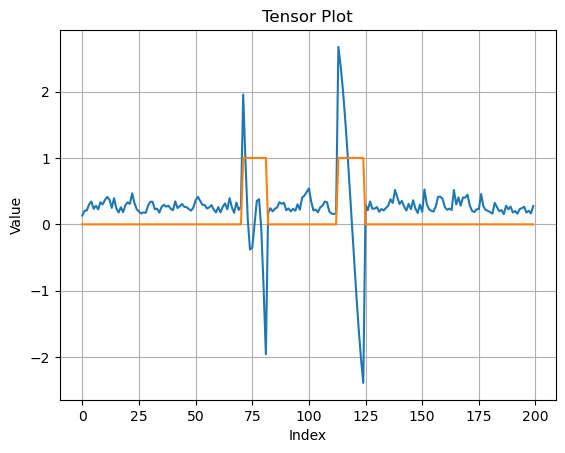

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
#

#plt.plot(x_one.to('cpu').reshape(-1))
plt.plot(x_one.to('cpu').reshape(-1))
plt.plot(gt_exps_one.to('cpu').reshape(-1))
plt.title('Tensor Plot')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)

# Show the plot
plt.show()

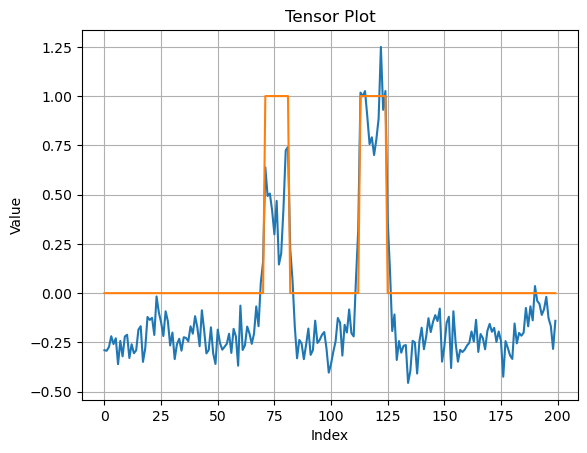

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
#

#plt.plot(x_one.to('cpu').reshape(-1))
plt.plot(output.detach().numpy().reshape(-1))
plt.plot(gt_exps_one.to('cpu').reshape(-1))
plt.title('Tensor Plot')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)

# Show the plot
plt.show()


In [30]:
x_flat=x_one.reshape(-1)
x_flat=x_flat.cpu().numpy()


In [31]:
series_1 = x_flat[:700]

In [20]:
import numpy as np

def dtw(sequence1, sequence2):
    n = len(sequence1)
    m = len(sequence2)
    
    # Create the cost matrix
    cost = np.zeros((n, m))
    
    # Initialize the first cell
    cost[0, 0] = abs(sequence1[0] - sequence2[0])
    
    # Initialize the first row and column
    for i in range(1, n):
        cost[i, 0] = cost[i-1, 0] + abs(sequence1[i] - sequence2[0])
        
    for j in range(1, m):
        cost[0, j] = cost[0, j-1] + abs(sequence1[0] - sequence2[j])
    
    # Populate the rest of the cost matrix
    for i in range(1, n):
        for j in range(1, m):
            min_cost = min(cost[i-1, j],    # Insertion
                           cost[i, j-1],    # Deletion
                           cost[i-1, j-1])  # Match
            cost[i, j] = abs(sequence1[i] - sequence2[j]) + min_cost
    
    # The DTW distance is the value in the bottom-right cell
    return cost[-1, -1]

In [21]:
import numpy as np

#from stumpy import motif

# Example time series data
  # Replace with your time series data
window_size = 50  # Choose an appropriate window size

# Using DTW to find similar sub-sequences
distances = []
for i in range(len(series) - window_size):
    subseq = series[i:i+window_size]
    for j in range(i+1, len(series) - window_size):
        other_subseq = series[j:j+window_size]
        distance = dtw(subseq, other_subseq)
        distances.append((distance, i, j))



# Using Matrix Profile for motif discovery
#mp = motif(series, window_size=window_size)
#motifs_indices = mp[0]

# Output the detected motifs
#print("Motif indices:", motifs_indices)

NameError: name 'motifs_indices' is not defined

In [31]:
print(len(distances[11113]))

3


In [1]:
import numpy as np
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

/home/hbs/.conda/envs/evrm_xts_1/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [32]:
distance, path = fastdtw(series_1, series, dist=euclidean)

In [40]:


def mark_similar_parts(series_a, series_b, threshold=0.1):
    # 初始化标注数组
    labels = np.zeros(len(series_a))

    # 计算DTW距离和路径
    distance, path = fastdtw(series_a, series_b, dist=euclidean)

    # 根据DTW距离标注相似部分
    if distance < threshold:
        # 将标注设置为1（相似部分）
        for (map_x, map_y) in path:
            labels[map_x] = 1

    return labels

# 示例时间序列

# 标注相似部分


In [49]:

def mark_translated_similar_parts(series_a, series_b, threshold=0.1):
    # 初始化标注数组
    labels = np.zeros(len(series_a))

    # 计算DTW距离和路径
    distance, path = fastdtw(series_a, series_b, dist=euclidean)

    # 如果距离小于阈值
    if distance < threshold:
        # 将相似部分标注为1
        for (map_x, map_y) in path:
            labels[map_x] = 1

        # 考虑平移，标注相邻的点
        for i in range(len(path) - 1):
            map_x, map_y = path[i]
            next_map_x, next_map_y = path[i + 1]
            # 标注相邻点
            if abs(next_map_x - map_x) <= 1:
                labels[next_map_x] = 1
            if abs(next_map_y - map_y) <= 1:
                labels[next_map_y] = 1

    return labels

In [47]:
labels = mark_translated_similar_parts(series_1, series)

In [48]:
print(labels)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.